<a href="https://colab.research.google.com/github/casualism/minecraft-diffusion/blob/main/minecraft_skin_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use


1.   Click on the small downards arrow next to Connect on the top right (or next Editing). Then View Resources > Change runtime type > GPU
2.   Click Runtime > Run All. This will take a while as it downloads and imports the necessary stuff. 




### Model

*   general_model - Trained on a dataset of 900 000 skins. Quality is not guaranteed (this model is really unstable during training for some reason), best used for anything other than unconditional generation and other stupid things. Recommended to use DDPM.

*   good_model - Trained on a clean dataset with largely eboy/egirl skins scraped from NameMC (I swear it was out of convinence). Quality is much higher but less diverse. 

### Sampler

* DDPM - Samples the full 1000 steps which the model was trains on. Produces best image quality
* DDIM - Samples a factor of 1000 steps. Lower quality but generates faster.

### Actions

* Unconditional generation - samples from the model without any sort of modification (generates random skins). 
* Generate variations - allows you to generate variations of a skin, tuned by the variability factor. Requires `reference_image_path` to be pointing to a skin
* Edits - Allows you to generate variations of a skin BUT only changes the masked parts. Requires an additional `mask_img_path`, this turns compares with the pixels from `reference_image_path` and turns it into the mask. Variability can be tuned.
* Edits + starting image - Allows you to do the same with edits BUT starts from a different image. Good for modifiying specific parts of the skin and letting the model change those around it. Variability can be tuned, and mask is created as per `Edits`, and the starting image is `masked_edits_image_path` (a bit misleading ik)

### Misc
* display_x0 - Displays what the model thinks the final output is rather than the actual image at the current timestep
* render - Uses MinePI to render the skin (to 3d) so it's interpretable
* generate_gif - saves the generation process to a gif. Just looks cool but takes significantly more time to finish.
* display frames - How many times to display the denoising process. 

### Additional info
* Add ur image paths to the files section (click on the file icon and click the file pointing up button), and copy the png file WITH DOUBLE QUOTED BRACKETS AND FORWARD SLASH -> ("/blah blah blah.png").
* Images & gifs are also saved there.
* Have fun and please don't read my convoluted code.



In [ ]:
#@title Imports and downloads
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from PIL import Image
import matplotlib.pyplot as plt
import imageio
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from google.colab import files

# Anti-disconnect
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

general_model = torch.hub.load('casualism/minecraft-diffusion', 'general_model',force_reload=True)
good_model = torch.hub.load('casualism/minecraft-diffusion', 'better_model',force_reload=True)

<IPython.core.display.Javascript object>

Downloading: "https://github.com/casualism/minecraft-diffusion/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/casualism/minecraft-diffusion/zipball/main" to /root/.cache/torch/hub/main.zip


In [ ]:
#@title MinePI renderer
# NOT MINE
# Modified from the MinePI library, removed the asynchronous stuff for a small speed boost
# https://pypi.org/project/MinePI/


from math import radians, sin, cos
import aiohttp
import json
import base64
import io
from PIL import Image, ImageDraw, ImageOps
import asyncio


def render_3d_skin(
        user: str = "",
        vr: int = -25,
        hr: int = 35,
        hrh: int = 0,
        vrll: int = 0,
        vrrl: int = 0,
        vrla: int = 0,
        vrra: int = 0,
        ratio: int = 12,
        display_hair: bool = True,
        display_second_layer: bool = True,
        aa: bool = False,
        skin_image: Image.Image = None
):
    """Render a full body skin

    Parameters
    ----------
    user: str
        Username or UUID of the player
    vr: int
        Vertical rotation of the output image
    hr: int
        Horizontal rotation of the output image
    hrh: int
        Horizontal head rotation
    vrll: int
        Vertical rotation of the left leg
    vrrl: int
        Vertical rotation of the right leg
    vrla: int
        Vertical rotation of the left arm
    vrra: int
        Vertical rotation of the right arm
    ratio: int
        Resolution of the returned image
    display_hair: bool
        Whether or not the second head layer should be displayed
    display_second_layer: bool
        Whether or not the second skin layer should be displayed
    aa: bool
        Antializing: smoothens the corners a bit
    skin_image: PIL.Image.Image
        minecraft skin image to prevent api calls

    Returns
    -------
    PIL.Image.Image
        The rendered skin

    Raises
    ------
    ValueError
        Given username and/or uuid is invalid
    """
    render = Render(user=user, vr=vr, hr=hr, hrh=hrh, vrll=vrll, vrrl=vrrl, vrla=vrla, vrra=vrra, ratio=ratio,
                    head_only=False, display_hair=display_hair, display_layers=display_second_layer, aa=aa)
    im = render.get_render(skin_image)
    del render
    return im


async def render_3d_head(
        user: str = "",
        vr: int = -25,
        hr: int = 35,
        ratio: int = 12,
        display_hair: bool = True,
        aa: bool = False,
        skin_image: Image.Image = None
):
    """Render a player's head

    Parameters
    ----------
    user: str
        Username or UUID of the player
    vr: int
        Vertical rotation of the output image
    hr: int
        Horizontal rotation of the output image
    ratio: int
        Resolution of the returned image
    display_hair: bool
        Whether or not the second head layer should be displayed
    display_second_layer: bool
        Whether or not the second skin layer should be displayed
    aa: bool
        Antializing: smoothens the corners a bit
    skin_image: PIL.Image.Image
        minecraft skin image to prevent api calls

    Returns
    -------
    PIL.Image.Image
        The rendered head

    Raises
    ------
    ValueError
        Given username and/or uuid is invalid
    """
    render = Render(user=user, vr=vr, hr=hr, hrh=0, vrll=0, vrrl=0, vrla=0, vrra=0, ratio=ratio, head_only=True,
                    display_hair=display_hair, display_layers=False, aa=aa)
    im = render.get_render(skin_image)
    del render
    return im


async def get_skin(user: str):
    """Get a player's raw skin image
    can be used in both :py:meth:`render_3d_head` and :py:meth:`render_3d_skin`

    Parameters
    ----------
    user: str
        Username or UUID

    Returns
    -------
    PIL.Image.Image
        Raw skin image

    Raises
    ------
    ValueError
        Username or UUID is invalid
    """
    render = Render(user, 0, 0, 0, 0, 0, 0, 0, 100, False, False, False, False)
    im = render.get_skin_mojang()
    del render
    return im


async def to_uuid(name: str):
    """Converts a username to a UUID by querying the mojang api

    Parameters
    ----------
    name: str
        Username you would like to convert

    Returns
    -------
    UUID: str
        The UUID of the player

    Raises
    ------
    ValueError
        Entered name is invalid
    """
    async with aiohttp.ClientSession() as session:
        async with session.get("https://api.mojang.com/users/profiles/minecraft/{}".format(name)) as resp:
            uuid_dict = json.loads(await resp.text())
            try:
                uuid = uuid_dict["id"]
                return uuid
            except KeyError:
                raise ValueError("Name {} is invalid".format(name))


async def to_name(uuid: str, timestamp: float = None):
    """Converts a UUID to a username by querying the mojang api

    Parameters
    ----------
    uuid: int
        uuid you would like to convert
    timestamp: float
        By passing this you can get old usernames

    Returns
    -------
    username: str
        The username of the player

    Raises
    ------
    ValueError
        Entered uuid is invalid
    """
    async with aiohttp.ClientSession() as session:
        async with session.get("https://api.mojang.com/user/profiles/{}/names".format(uuid)) as resp:
            name_dict = json.loads(await resp.text())
            if resp.status == 200:
                if timestamp == None:
                    max_entry = len(name_dict) - 1
                    name = name_dict[max_entry]["name"]
                    return name
                else:
                    for i in range(len(name_dict) - 1, 0, -1):
                        if timestamp > name_dict[i]["changedToAt"]:
                            return name_dict[i]["name"]
                    else:
                        return name_dict[0]["name"]
            elif resp.status == 400:
                raise ValueError(name_dict["errorMessage"])


def is_not_existing(dic, key1=None, key2=None, key3=None):
    try:
        if key1 == None:
            resp = dic
        if key2 == None:
            resp = dic[key1]
        elif key3 == None:
            resp = dic[key1][key2]
        else:
            resp = dic[key1][key2][key3]
        return False
    except KeyError:
        return True


def append_dict(dic, key1, key2, key3, value):
    if is_not_existing(dic, key1, key2, key3):
        try:
            dic[key1][key2][key3] = value
        except KeyError:
            try:
                dic[key1][key2] = {}
                dic[key1][key2][key3] = value
            except KeyError:
                dic[key1] = {}
                dic[key1][key2] = {}
                dic[key1][key2][key3] = value
    return dic


class Render:
    def __init__(self, user: str, vr: int, hr: int, hrh: int, vrll: int, vrrl: int, vrla: int, vrra: int, ratio: int,
                 head_only: bool, display_hair: bool, display_layers: bool, aa: bool):
        self.is_new_skin = True
        self.vr = vr
        self.hr = hr
        self.hrh = hrh
        self.vrll = vrll
        self.vrrl = vrrl
        self.vrla = vrla
        self.vrra = vrra
        self.head_only = head_only
        self.ratio = ratio
        self.display_hair = display_hair
        self.layers = display_layers
        self.user = user
        self.aa = aa
        self.rendered_image = None

        self.cos_a = None
        self.sin_a = None
        self.cos_b = None
        self.sin_b = None

        self.min_x = 0
        self.max_x = 0
        self.min_y = 0
        self.max_y = 0

    async def get_skin_mojang(self):
        if len(self.user) <= 16:
            async with aiohttp.ClientSession() as session:
                async with session.get(f"https://api.mojang.com/users/profiles/minecraft/{self.user}") as response:
                    resp = await response.text()
            if response.status != 200:
                raise ValueError("Username is invalid")
            resp = json.loads(resp)
            uuid = resp["id"]
            uuid = uuid.replace("-", "")
        else:
            uuid = self.user.replace("-", "")

        if len(uuid) == 32:
            for ch in uuid:
                if (ch < '0' or ch > '9') and (ch.lower() < 'a' or ch.lower() > 'f'):
                    raise ValueError("UUID is invalid")
            else:
                async with aiohttp.ClientSession() as session:
                    async with session.get(
                            f"https://sessionserver.mojang.com/session/minecraft/profile/{uuid}") as resp:
                        resp_sessionserver = await resp.text()
            if resp_sessionserver == "":
                raise ValueError("UUID is invalid")
            resp_sessionserver = json.loads(resp_sessionserver)
            skin_array = resp_sessionserver["properties"][0]["value"]
            skin_array = json.loads((base64.b64decode(skin_array)))
            skin_url = skin_array["textures"]["SKIN"]["url"]

            async with aiohttp.ClientSession() as session:
                async with session.get(skin_url) as resp:
                    im = Image.open(io.BytesIO(await resp.read()))
        else:
            raise ValueError("Invalid Username or UUID")

        return im

    def get_render(self, skin):
        # if skin == None:
        #     skin = await self.get_skin_mojang()
        hd_ratio = int(skin.size[0] / 64)

        if skin.height == 32:
            skin = self.fix_old_skins(skin)

        self.calculate_angles()
        self.determine_faces()
        self.generate_polygons(hd_ratio, skin)
        self.member_rotation(hd_ratio)
        self.create_project_plan()

        return self.display_image()

    def fix_old_skins(self, skin: Image):
        # resize the image to 64/64px
        new_skin = Image.new("RGBA", (skin.width, 64), (0, 0, 0, 0))
        new_skin.paste(skin, (0, 0))

        # copy the leg
        leg_top = ImageOps.mirror(skin.crop((4, 16, 8, 20)))
        leg_bottom = ImageOps.mirror(skin.crop((8, 16, 12, 20)))
        leg_left = ImageOps.mirror(skin.crop((8, 20, 12, 32)))
        leg_back = ImageOps.mirror(skin.crop((12, 20, 16, 32)))
        leg_front = ImageOps.mirror(skin.crop((4, 20, 8, 32)))
        leg_right = ImageOps.mirror(skin.crop((0, 20, 4, 32)))

        new_skin.paste(leg_top, (20, 48))
        new_skin.paste(leg_bottom, (24, 48))
        new_skin.paste(leg_left, (16, 52))
        new_skin.paste(leg_front, (20, 52))
        new_skin.paste(leg_right, (24, 52))
        new_skin.paste(leg_back, (28, 52))

        # copy the arm
        arm_top = ImageOps.mirror(skin.crop((44, 16, 48, 20)))
        arm_bottom = ImageOps.mirror(skin.crop((48, 16, 52, 20)))
        arm_left = ImageOps.mirror(skin.crop((48, 20, 52, 32)))
        arm_back = ImageOps.mirror(skin.crop((52, 20, 56, 32)))
        arm_front = ImageOps.mirror(skin.crop((44, 20, 48, 32)))
        arm_right = ImageOps.mirror(skin.crop((40, 20, 44, 32)))

        new_skin.paste(arm_top, (36, 48))
        new_skin.paste(arm_bottom, (40, 48))
        new_skin.paste(arm_left, (32, 52))
        new_skin.paste(arm_front, (36, 52))
        new_skin.paste(arm_right, (40, 52))
        new_skin.paste(arm_back, (44, 52))

        return new_skin

    def calculate_angles(self):
        self.body_angles = {}
        alpha = radians(self.vr)
        beta = radians(self.hr)

        self.cos_a, self.sin_a = cos(alpha), sin(alpha)
        self.cos_b, self.sin_b = cos(beta), sin(beta)

        self.body_angles["torso"] = (cos(0), sin(0), cos(0), sin(0))
        self.body_angles["torso_layer"] = (cos(0), sin(0), cos(0), sin(0))

        alpha_head = 0
        beta_head = radians(self.hrh)
        self.body_angles["head"] = (cos(alpha_head), sin(alpha_head), cos(beta_head), sin(beta_head))
        self.body_angles["helmet"] = (cos(alpha_head), sin(alpha_head), cos(beta_head), sin(beta_head))

        alpha_r_arm = radians(self.vrra)
        beta_r_arm = 0
        self.body_angles["r_arm"] = (cos(alpha_r_arm), sin(alpha_r_arm), cos(beta_r_arm), sin(beta_r_arm))
        self.body_angles["r_arm_layer"] = (cos(alpha_r_arm), sin(alpha_r_arm), cos(beta_r_arm), sin(beta_r_arm))

        alpha_l_arm = radians(self.vrla)
        beta_l_arm = 0
        self.body_angles["l_arm"] = (cos(alpha_l_arm), sin(alpha_l_arm), cos(beta_l_arm), sin(beta_l_arm))
        self.body_angles["l_arm_layer"] = (cos(alpha_l_arm), sin(alpha_l_arm), cos(beta_l_arm), sin(beta_l_arm))

        alpha_r_leg = radians(self.vrrl)
        beta_r_leg = 0
        self.body_angles["r_leg"] = (cos(alpha_r_leg), sin(alpha_r_leg), cos(beta_r_leg), sin(beta_r_leg))
        self.body_angles["r_leg_layer"] = (cos(alpha_r_leg), sin(alpha_r_leg), cos(beta_r_leg), sin(beta_r_leg))

        alpha_l_leg = radians(self.vrll)
        beta_l_leg = 0
        self.body_angles["l_leg"] = (cos(alpha_l_leg), sin(alpha_l_leg), cos(beta_l_leg), sin(beta_l_leg))
        self.body_angles["l_leg_layer"] = (cos(alpha_l_leg), sin(alpha_l_leg), cos(beta_l_leg), sin(beta_l_leg))

    def determine_faces(self):
        self.visible_faces = {
            "head": {"front": {}, "back": {}},
            "torso": {"front": {}, "back": {}},
            "torso_layer": {"front": {}, "back": {}},
            "r_arm": {"front": {}, "back": {}},
            "r_arm_layer": {"front": {}, "back": {}},
            "l_arm": {"front": {}, "back": {}},
            "l_arm_layer": {"front": {}, "back": {}},
            "r_leg": {"front": {}, "back": {}},
            "r_leg_layer": {"front": {}, "back": {}},
            "l_leg": {"front": {}, "back": {}},
            "l_leg_layer": {"front": {}, "back": {}}
        }

        self.all_faces = ["back", "right", "top", "front", "left", "bottom"]

        for k, v in self.visible_faces.items():
            cube_max_depth_faces = None
            self.set_cube_points()

            for cube_point in self.cube_points:
                cube_point[0].pre_project(0, 0, 0, self.body_angles[k][0], self.body_angles[k][1],
                                          self.body_angles[k][2], self.body_angles[k][3])
                cube_point[0].project()

                if (cube_max_depth_faces == None) or (cube_max_depth_faces[0].get_depth() > cube_point[0].get_depth()):
                    cube_max_depth_faces = cube_point

            v["back"] = cube_max_depth_faces[1]
            v["front"] = [face for face in self.all_faces if face not in v["back"]]

        self.set_cube_points()
        cube_max_depth_faces = None
        for cube_point in self.cube_points:
            cube_point[0].project()

            if (cube_max_depth_faces == None) or (cube_max_depth_faces[0].get_depth() > cube_point[0].get_depth()):
                cube_max_depth_faces = cube_point

            self.back_faces = cube_max_depth_faces[1]
            self.front_faces = [face for face in self.all_faces if face not in self.back_faces]

    def set_cube_points(self):
        self.cube_points = []
        self.cube_points.append((Point(self, {
            "x": 0,
            "y": 0,
            "z": 0
        }),
                                 ["back", "right", "top"]
                                 ))

        self.cube_points.append((Point(self, {
            "x": 0,
            "y": 0,
            "z": 1
        }),
                                 ["front", "right", "top"]
                                 ))

        self.cube_points.append((Point(self, {
            "x": 0,
            "y": 1,
            "z": 0
        }),
                                 ["back", "right", "bottom"]
                                 ))

        self.cube_points.append((Point(self, {
            "x": 0,
            "y": 1,
            "z": 1
        }),
                                 ["front", "right", "bottom"]
                                 ))

        self.cube_points.append((Point(self, {
            "x": 1,
            "y": 0,
            "z": 0
        }),
                                 ["back", "left", "top"]
                                 ))

        self.cube_points.append((Point(self, {
            "x": 1,
            "y": 0,
            "z": 1
        }),
                                 ["front", "left", "top"]
                                 ))

        self.cube_points.append((Point(self, {
            "x": 1,
            "y": 1,
            "z": 0
        }),
                                 ["back", "left", "bottom"]
                                 ))

        self.cube_points.append((Point(self, {
            "x": 1,
            "y": 1,
            "z": 1
        }),
                                 ["front", "left", "bottom"]
                                 ))

    def generate_polygons(self, hd_ratio, skin):
        self.polygons = {
            "helmet": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "head": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "torso": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "torso_layer": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "r_arm": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "r_arm_layer": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "l_arm": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "l_arm_layer": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "r_leg": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "r_leg_layer": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "l_leg": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []},
            "l_leg_layer": {"front": [], "back": [], "top": [], "bottom": [], "right": [], "left": []}
        }

        """Head"""
        volume_points = {}
        for i in range(0, 9 * hd_ratio):
            for j in range(0, 9 * hd_ratio):
                volume_points = append_dict(volume_points, i, j, -2 * hd_ratio,
                                            Point(self, {"x": i, "y": j, "z": -2 * hd_ratio}))
                volume_points = append_dict(volume_points, i, j, 6 * hd_ratio,
                                            Point(self, {"x": i, "y": j, "z": 6 * hd_ratio}))

        for j in range(0, 9 * hd_ratio):
            for k in range(-2 * hd_ratio, 7 * hd_ratio):
                volume_points = append_dict(volume_points, 0, j, k, Point(self, {"x": 0, "y": j, "z": k}))
                volume_points = append_dict(volume_points, 8 * hd_ratio, j, k,
                                            Point(self, {"x": 8 * hd_ratio, "y": j, "z": k}))

        for i in range(0, 9 * hd_ratio):
            for k in range(-2 * hd_ratio, 7 * hd_ratio):
                volume_points = append_dict(volume_points, i, 0, k, Point(self, {"x": i, "y": 0, "z": k}))
                volume_points = append_dict(volume_points, i, 8 * hd_ratio, k,
                                            Point(self, {"x": i, "y": 8 * hd_ratio, "z": k}))

        if "back" in self.visible_faces["head"]["front"]:
            for i in range(0, 8 * hd_ratio):
                for j in range(0, 8 * hd_ratio):
                    color = skin.getpixel((32 * hd_ratio - 1 - i, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["head"]["back"].append(Polygon([
                            volume_points[i][j][-2 * hd_ratio],
                            volume_points[i + 1][j][-2 * hd_ratio],
                            volume_points[i + 1][j + 1][-2 * hd_ratio],
                            volume_points[i][j + 1][-2 * hd_ratio]],
                            color))

        if "front" in self.visible_faces["head"]["front"]:
            for i in range(0, 8 * hd_ratio):
                for j in range(0, 8 * hd_ratio):
                    color = skin.getpixel((8 * hd_ratio + i, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["head"]["front"].append(Polygon([
                            volume_points[i][j][6 * hd_ratio],
                            volume_points[i + 1][j][6 * hd_ratio],
                            volume_points[i + 1][j + 1][6 * hd_ratio],
                            volume_points[i][j + 1][6 * hd_ratio]],
                            color))

        if "right" in self.visible_faces["head"]["front"]:
            for j in range(0, 8 * hd_ratio):
                for k in range(-2 * hd_ratio, 6 * hd_ratio):
                    color = skin.getpixel((k + 2 * hd_ratio, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["head"]["right"].append(Polygon([
                            volume_points[0][j][k],
                            volume_points[0][j][k + 1],
                            volume_points[0][j + 1][k + 1],
                            volume_points[0][j + 1][k]],
                            color))

        if "left" in self.visible_faces["head"]["front"]:
            for j in range(0, 8 * hd_ratio):
                for k in range(-2 * hd_ratio, 6 * hd_ratio):
                    color = skin.getpixel(((24 * hd_ratio - 1) - k - 2 * hd_ratio, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["head"]["left"].append(Polygon([
                            volume_points[8 * hd_ratio][j][k],
                            volume_points[8 * hd_ratio][j][k + 1],
                            volume_points[8 * hd_ratio][j + 1][k + 1],
                            volume_points[8 * hd_ratio][j + 1][k]],
                            color))

        if "top" in self.visible_faces["head"]["front"]:
            for i in range(0, 8 * hd_ratio):
                for k in range(-2 * hd_ratio, 6 * hd_ratio):
                    color = skin.getpixel((8 * hd_ratio + i, 2 * hd_ratio + k))
                    if color[3] != 0:
                        self.polygons["head"]["top"].append(Polygon([
                            volume_points[i][0][k],
                            volume_points[i + 1][0][k],
                            volume_points[i + 1][0][k + 1],
                            volume_points[i][0][k + 1]],
                            color))

        if "bottom" in self.visible_faces["head"]["front"]:
            for i in range(0, 8 * hd_ratio):
                for k in range(-2 * hd_ratio, 6 * hd_ratio):
                    color = skin.getpixel((16 * hd_ratio + i, 2 * hd_ratio + k))
                    if color[3] != 0:
                        self.polygons["head"]["bottom"].append(Polygon([
                            volume_points[i][8 * hd_ratio][k],
                            volume_points[i + 1][8 * hd_ratio][k],
                            volume_points[i + 1][8 * hd_ratio][k + 1],
                            volume_points[i][8 * hd_ratio][k + 1]],
                            color))

        """Helmet / Hair"""
        if self.display_hair:
            volume_points = {}
            for i in range(0, 9 * hd_ratio):
                for j in range(0, 9 * hd_ratio):
                    volume_points = append_dict(volume_points, i, j, -2 * hd_ratio, Point(self, {
                        "x": i * 8.5 / 8 - 0.25 * hd_ratio, "y": j * 8.5 / 8 - 0.25 * hd_ratio, "z": -2.25 * hd_ratio}))
                    volume_points = append_dict(volume_points, i, j, 6 * hd_ratio, Point(self, {
                        "x": i * 8.5 / 8 - 0.25 * hd_ratio, "y": j * 8.5 / 8 - 0.25 * hd_ratio, "z": 6.25 * hd_ratio}))

            for j in range(0, 9 * hd_ratio):
                for k in range(-2 * hd_ratio, 7 * hd_ratio):
                    volume_points = append_dict(volume_points, 0, j, k, Point(self, {"x": -0.25 * hd_ratio,
                                                                                     "y": j * 8.5 / 8 - 0.25 * hd_ratio,
                                                                                     "z": k * 8.5 / 8 - 0.25 * hd_ratio}))
                    volume_points = append_dict(volume_points, 8 * hd_ratio, j, k, Point(self, {"x": 8.25 * hd_ratio,
                                                                                                "y": j * 8.5 / 8 - 0.25 * hd_ratio,
                                                                                                "z": k * 8.5 / 8 - 0.25 * hd_ratio}))

            for i in range(0, 9 * hd_ratio):
                for k in range(-2 * hd_ratio, 7 * hd_ratio):
                    volume_points = append_dict(volume_points, i, 0, k, Point(self, {"x": i * 8.5 / 8 - 0.25 * hd_ratio,
                                                                                     "y": -0.25 * hd_ratio,
                                                                                     "z": k * 8.5 / 8 - 0.25 * hd_ratio}))
                    volume_points = append_dict(volume_points, i, 8 * hd_ratio, k, Point(self, {
                        "x": i * 8.5 / 8 - 0.25 * hd_ratio, "y": 8.25 * hd_ratio, "z": k * 8.5 / 8 - 0.25 * hd_ratio}))

            for i in range(0, 8 * hd_ratio):
                for j in range(0, 8 * hd_ratio):
                    color = skin.getpixel((64 * hd_ratio - 1 - i, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["helmet"]["back"].append(Polygon([
                            volume_points[i][j][-2 * hd_ratio],
                            volume_points[i + 1][j][-2 * hd_ratio],
                            volume_points[i + 1][j + 1][-2 * hd_ratio],
                            volume_points[i][j + 1][-2 * hd_ratio]],
                            color))
                    color = skin.getpixel((40 * hd_ratio + i, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["helmet"]["front"].append(Polygon([
                            volume_points[i][j][6 * hd_ratio],
                            volume_points[i + 1][j][6 * hd_ratio],
                            volume_points[i + 1][j + 1][6 * hd_ratio],
                            volume_points[i][j + 1][6 * hd_ratio]],
                            color))

            for j in range(0, 8 * hd_ratio):
                for k in range(-2 * hd_ratio, 6 * hd_ratio):
                    color = skin.getpixel((34 * hd_ratio + k, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["helmet"]["right"].append(Polygon([
                            volume_points[0][j][k],
                            volume_points[0][j][k + 1],
                            volume_points[0][j + 1][k + 1],
                            volume_points[0][j + 1][k]],
                            color))
                    color = skin.getpixel((54 * hd_ratio - k - 1, 8 * hd_ratio + j))
                    if color[3] != 0:
                        self.polygons["helmet"]["left"].append(Polygon([
                            volume_points[8 * hd_ratio][j][k],
                            volume_points[8 * hd_ratio][j][k + 1],
                            volume_points[8 * hd_ratio][j + 1][k + 1],
                            volume_points[8 * hd_ratio][j + 1][k]],
                            color))

            for i in range(0, 8 * hd_ratio):
                for k in range(-2 * hd_ratio, 6 * hd_ratio):
                    color = skin.getpixel((40 * hd_ratio + i, 2 * hd_ratio + k))
                    if color[3] != 0:
                        self.polygons["helmet"]["top"].append(Polygon([
                            volume_points[i][0][k],
                            volume_points[i + 1][0][k],
                            volume_points[i + 1][0][k + 1],
                            volume_points[i][0][k + 1]],
                            color))
                    color = skin.getpixel((48 * hd_ratio + 1, 2 * hd_ratio + k))
                    if color[3] != 0:
                        self.polygons["helmet"]["bottom"].append(Polygon([
                            volume_points[i][8 * hd_ratio][k],
                            volume_points[i + 1][8 * hd_ratio][k],
                            volume_points[i + 1][8 * hd_ratio][k + 1],
                            volume_points[i][8 * hd_ratio][k + 1]],
                            color))

        if self.head_only == False:
            """Torso"""
            volume_points = {}
            for i in range(0, 9 * hd_ratio):
                for j in range(0, 13 * hd_ratio):
                    volume_points = append_dict(volume_points, i, j, 0,
                                                Point(self, {"x": i, "y": j + 8 * hd_ratio, "z": 0}))
                    volume_points = append_dict(volume_points, i, j, 4 * hd_ratio,
                                                Point(self, {"x": i, "y": j + 8 * hd_ratio, "z": 4 * hd_ratio}))

            for j in range(0, 13 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, 0, j, k,
                                                Point(self, {"x": 0, "y": j + 8 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, 8 * hd_ratio, j, k,
                                                Point(self, {"x": 8 * hd_ratio, "y": j + 8 * hd_ratio, "z": k}))

            for i in range(0, 9 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, i, 0, k,
                                                Point(self, {"x": i, "y": 8 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, i, 12 * hd_ratio, k,
                                                Point(self, {"x": i, "y": 20 * hd_ratio, "z": k}))

            if "back" in self.visible_faces["torso"]["front"]:
                for i in range(0, 8 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel(((40 * hd_ratio - 1) - i, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["torso"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))

            if "front" in self.visible_faces["torso"]["front"]:
                for i in range(0, 8 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((20 * hd_ratio + i, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["torso"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

            if "right" in self.visible_faces["torso"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0 * hd_ratio, 4 * hd_ratio):
                        color = skin.getpixel((16 * hd_ratio + k, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["torso"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))

            if "left" in self.visible_faces["torso"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0 * hd_ratio, 4 * hd_ratio):
                        color = skin.getpixel(((32 * hd_ratio - 1) - k, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["torso"]["left"].append(Polygon([
                                volume_points[8 * hd_ratio][j][k],
                                volume_points[8 * hd_ratio][j][k + 1],
                                volume_points[8 * hd_ratio][j + 1][k + 1],
                                volume_points[8 * hd_ratio][j + 1][k]],
                                color))

            if "top" in self.visible_faces["torso"]["front"]:
                for i in range(0, 8 * hd_ratio):
                    for k in range(0 * hd_ratio, 4 * hd_ratio):
                        color = skin.getpixel((20 * hd_ratio + i, 16 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["torso"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))

            if "bottom" in self.visible_faces["torso"]["front"]:
                for i in range(0, 8 * hd_ratio):
                    for k in range(0 * hd_ratio, 4 * hd_ratio):
                        color = skin.getpixel((28 * hd_ratio + i, (20 * hd_ratio - 1) - k))
                        if color[3] != 0:
                            self.polygons["torso"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Torso 2nd layer"""
            if self.layers:
                volume_points = {}
                for i in range(0, 9 * hd_ratio):
                    for j in range(0, 13 * hd_ratio):
                        volume_points = append_dict(volume_points, i, j, 0, Point(self,
                                                                                  {"x": i * 8.25 / 8 - 0.125 * hd_ratio,
                                                                                   "y": (
                                                                                                    j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio,
                                                                                   "z": -0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {
                            "x": i * 8.25 / 8 - 0.125 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio, "z": 4.125 * hd_ratio}))

                for j in range(0, 13 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, 0, j, k, Point(self, {"x": -0.125 * hd_ratio, "y": (
                                                                                                                                  j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio,
                                                                                         "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, 8 * hd_ratio, j, k, Point(self,
                                                                                             {"x": 8.125 * hd_ratio,
                                                                                              "y": (
                                                                                                               j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio,
                                                                                              "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 9 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, i, 0, k, Point(self,
                                                                                  {"x": i * 8.25 / 8 - 0.125 * hd_ratio,
                                                                                   "y": 7.875 * hd_ratio,
                                                                                   "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, 12 * hd_ratio, k, Point(self, {
                            "x": i * 8.25 / 8 - 0.125 * hd_ratio, "y": 20.125 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 8 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel(((40 * hd_ratio - 1) - i, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["torso_layer"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))
                        color = skin.getpixel((20 * hd_ratio + i, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["torso_layer"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

                for j in range(0, 12 * hd_ratio):
                    for k in range(0 * hd_ratio, 4 * hd_ratio):
                        color = skin.getpixel((16 * hd_ratio + k, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["torso_layer"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))
                        color = skin.getpixel(((32 * hd_ratio - 1) - k, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["torso_layer"]["left"].append(Polygon([
                                volume_points[8 * hd_ratio][j][k],
                                volume_points[8 * hd_ratio][j][k + 1],
                                volume_points[8 * hd_ratio][j + 1][k + 1],
                                volume_points[8 * hd_ratio][j + 1][k]],
                                color))

                for i in range(0, 8 * hd_ratio):
                    for k in range(0 * hd_ratio, 4 * hd_ratio):
                        color = skin.getpixel((20 * hd_ratio + i, 16 * hd_ratio + k + 16))
                        if color[3] != 0:
                            self.polygons["torso_layer"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))
                        color = skin.getpixel((28 * hd_ratio + i, (20 * hd_ratio - 1) - k + 16))
                        if color[3] != 0:
                            self.polygons["torso_layer"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Right arm"""
            volume_points = {}
            for i in range(0, 5 * hd_ratio):
                for j in range(0, 13 * hd_ratio):
                    volume_points = append_dict(volume_points, i, j, 0,
                                                Point(self, {"x": i - 4 * hd_ratio, "y": j + 8 * hd_ratio, "z": 0}))
                    volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {"x": i - 4 * hd_ratio,
                                                                                                "y": j + 8 * hd_ratio,
                                                                                                "z": 4 * hd_ratio}))

            for j in range(0, 13 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, 0, j, k,
                                                Point(self, {"x": -4 * hd_ratio, "y": j + 8 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, 4 * hd_ratio, j, k,
                                                Point(self, {"x": 0, "y": j + 8 * hd_ratio, "z": k}))

            for i in range(0, 5 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, i, 0, k,
                                                Point(self, {"x": i - 4 * hd_ratio, "y": 8 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, i, 12 * hd_ratio, k,
                                                Point(self, {"x": i - 4 * hd_ratio, "y": 20 * hd_ratio, "z": k}))

            if "back" in self.visible_faces["r_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel(((56 * hd_ratio - 1) - i, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_arm"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))

            if "front" in self.visible_faces["r_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((44 * hd_ratio + i, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_arm"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

            if "right" in self.visible_faces["r_arm"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((40 * hd_ratio + k, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_arm"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))

            if "left" in self.visible_faces["r_arm"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel(((52 * hd_ratio - 1) - k, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_arm"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color))

            if "top" in self.visible_faces["r_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((44 * hd_ratio + i, 16 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["r_arm"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))

            if "bottom" in self.visible_faces["r_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((48 * hd_ratio + i, 16 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["r_arm"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Right arm 2nd layer"""
            if self.layers:
                volume_points = {}
                for i in range(0, 5 * hd_ratio):
                    for j in range(0, 13 * hd_ratio):
                        volume_points = append_dict(volume_points, i, j, 0, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) - 4 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio, "z": -0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) - 4 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio, "z": 4.125 * hd_ratio}))

                for j in range(0, 13 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, 0, j, k, Point(self, {"x": -4.125 * hd_ratio, "y": (
                                                                                                                                  j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio,
                                                                                         "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, 4 * hd_ratio, j, k, Point(self,
                                                                                             {"x": 0.125 * hd_ratio,
                                                                                              "y": (
                                                                                                               j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio,
                                                                                              "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 5 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, i, 0, k, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) - 4 * hd_ratio, "y": 7.875 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, 12 * hd_ratio, k, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) - 4 * hd_ratio, "y": 20.125 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel(((56 * hd_ratio - 1) - i, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["r_arm_layer"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))
                        color = skin.getpixel((44 * hd_ratio + i, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["r_arm_layer"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((40 * hd_ratio + k, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["r_arm_layer"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))
                        color = skin.getpixel(((52 * hd_ratio - 1) - k, 20 * hd_ratio + j + 16))
                        if color[3] != 0:
                            self.polygons["r_arm_layer"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color))

                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((44 * hd_ratio + i, 16 * hd_ratio + k + 16))
                        if color[3] != 0:
                            self.polygons["r_arm_layer"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))
                        color = skin.getpixel((48 * hd_ratio + i, 16 * hd_ratio + k + 16))
                        if color[3] != 0:
                            self.polygons["r_arm_layer"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Left arm"""
            volume_points = {}
            for i in range(0, 5 * hd_ratio):
                for j in range(0, 13 * hd_ratio):
                    volume_points = append_dict(volume_points, i, j, 0,
                                                Point(self, {"x": i + 8 * hd_ratio, "y": j + 8 * hd_ratio, "z": 0}))
                    volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {"x": i + 8 * hd_ratio,
                                                                                                "y": j + 8 * hd_ratio,
                                                                                                "z": 4 * hd_ratio}))

            for j in range(0, 13 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, 0, j, k,
                                                Point(self, {"x": 8 * hd_ratio, "y": j + 8 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, 4 * hd_ratio, j, k,
                                                Point(self, {"x": 12 * hd_ratio, "y": j + 8 * hd_ratio, "z": k}))

            for i in range(0, 5 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, i, 0, k,
                                                Point(self, {"x": i + 8 * hd_ratio, "y": 8 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, i, 12 * hd_ratio, k,
                                                Point(self, {"x": i + 8 * hd_ratio, "y": 20 * hd_ratio, "z": k}))

            if "back" in self.visible_faces["l_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((48 * hd_ratio - 1 - i, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))

            if "front" in self.visible_faces["l_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((36 * hd_ratio + i, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

            if "right" in self.visible_faces["l_arm"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((32 * hd_ratio + k, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))

            if "left" in self.visible_faces["l_arm"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((44 * hd_ratio - 1 - k, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color))

            if "top" in self.visible_faces["l_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((36 * hd_ratio + i, 48 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["l_arm"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))

            if "bottom" in self.visible_faces["l_arm"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((40 * hd_ratio + i, 48 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["l_arm"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Left arm 2nd layer"""
            if self.layers:
                volume_points = {}
                for i in range(0, 5 * hd_ratio):
                    for j in range(0, 13 * hd_ratio):
                        volume_points = append_dict(volume_points, i, j, 0, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 8 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio, "z": -0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 8 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio, "z": 4.125 * hd_ratio}))

                for j in range(0, 13 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, 0, j, k, Point(self, {"x": 7.875 * hd_ratio, "y": (
                                                                                                                                 j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio,
                                                                                         "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, 4 * hd_ratio, j, k, Point(self,
                                                                                             {"x": 12.125 * hd_ratio,
                                                                                              "y": (
                                                                                                               j * 12.25 / 12 - 0.125 * hd_ratio) + 8 * hd_ratio,
                                                                                              "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 5 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, i, 0, k, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 8 * hd_ratio, "y": 7.875 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, 12 * hd_ratio, k, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 8 * hd_ratio, "y": 20.125 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((64 * hd_ratio - 1 - i, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm_layer"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))
                        color = skin.getpixel((52 * hd_ratio + i, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm_layer"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((48 * hd_ratio + k, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm_layer"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))
                        color = skin.getpixel((60 * hd_ratio - 1 - k, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_arm_layer"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color))

                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((52 * hd_ratio + i, 48 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["l_arm_layer"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))
                        color = skin.getpixel((56 * hd_ratio + i, 48 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["l_arm_layer"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Right leg"""
            volume_points = {}
            for i in range(0, 5 * hd_ratio):
                for j in range(0, 13 * hd_ratio):
                    volume_points = append_dict(volume_points, i, j, 0,
                                                Point(self, {"x": i, "y": j + 20 * hd_ratio, "z": 0}))
                    volume_points = append_dict(volume_points, i, j, 4 * hd_ratio,
                                                Point(self, {"x": i, "y": j + 20 * hd_ratio, "z": 4 * hd_ratio}))

            for j in range(0, 13 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, 0, j, k,
                                                Point(self, {"x": 0, "y": j + 20 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, 4 * hd_ratio, j, k,
                                                Point(self, {"x": 4 * hd_ratio, "y": j + 20 * hd_ratio, "z": k}))

            for i in range(0, 5 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, i, 0, k,
                                                Point(self, {"x": i, "y": 20 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, i, 12 * hd_ratio, k,
                                                Point(self, {"x": i, "y": 32 * hd_ratio, "z": k}))

            if "back" in self.visible_faces["r_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel(((16 * hd_ratio - 1) - i, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))

            if "front" in self.visible_faces["r_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((4 * hd_ratio + i, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

            if "right" in self.visible_faces["r_leg"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((k, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))

            if "left" in self.visible_faces["r_leg"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel(((12 * hd_ratio - 1) - k, 20 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color))

            if "top" in self.visible_faces["r_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((4 * hd_ratio + i, 16 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["r_leg"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))

            if "bottom" in self.visible_faces["r_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((8 * hd_ratio + i, 16 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["r_leg"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Right leg 2nd layer"""
            if self.layers:
                volume_points = {}
                for i in range(0, 5 * hd_ratio):
                    for j in range(0, 13 * hd_ratio):
                        volume_points = append_dict(volume_points, i, j, 0, Point(self,
                                                                                  {"x": i * 4.25 / 4 - 0.125 * hd_ratio,
                                                                                   "y": (
                                                                                                    j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio,
                                                                                   "z": -0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {
                            "x": i * 4.25 / 4 - 0.125 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio, "z": 4.125 * hd_ratio}))

                for j in range(0, 13 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, 0, j, k, Point(self, {"x": -0.125 * hd_ratio, "y": (
                                                                                                                                  j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio,
                                                                                         "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, 4 * hd_ratio, j, k, Point(self,
                                                                                             {"x": 4.125 * hd_ratio,
                                                                                              "y": (
                                                                                                               j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio,
                                                                                              "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 5 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, i, 0, k, Point(self,
                                                                                  {"x": i * 4.25 / 4 - 0.125 * hd_ratio,
                                                                                   "y": 19.875 * hd_ratio,
                                                                                   "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, 12 * hd_ratio, k, Point(self, {
                            "x": i * 4.25 / 4 - 0.125 * hd_ratio, "y": 32.125 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((16 * hd_ratio - 1 - i, 36 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg_layer"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))
                        color = skin.getpixel((4 * hd_ratio + i, 36 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg_layer"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((k, 36 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg_layer"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))
                        color = skin.getpixel((12 * hd_ratio - 1 - k, 36 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["r_leg_layer"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color))

                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((4 * hd_ratio + i, 32 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["r_leg_layer"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))
                        color = skin.getpixel((8 * hd_ratio + i, 32 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["r_leg_layer"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Left leg"""
            volume_points = {}
            for i in range(0, 9 * hd_ratio):
                for j in range(0, 13 * hd_ratio):
                    volume_points = append_dict(volume_points, i, j, 0,
                                                Point(self, {"x": i + 4 * hd_ratio, "y": j + 20 * hd_ratio, "z": 0}))
                    volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {"x": i + 4 * hd_ratio,
                                                                                                "y": j + 20 * hd_ratio,
                                                                                                "z": 4 * hd_ratio}))

            for j in range(0, 13 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, 0, j, k,
                                                Point(self, {"x": 4 * hd_ratio, "y": j + 20 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, 4 * hd_ratio, j, k,
                                                Point(self, {"x": 8 * hd_ratio, "y": j + 20 * hd_ratio, "z": k}))

            for i in range(0, 9 * hd_ratio):
                for k in range(0, 5 * hd_ratio):
                    volume_points = append_dict(volume_points, i, 0, k,
                                                Point(self, {"x": i + 4 * hd_ratio, "y": 20 * hd_ratio, "z": k}))
                    volume_points = append_dict(volume_points, i, 12 * hd_ratio, k,
                                                Point(self, {"x": i + 4 * hd_ratio, "y": 32 * hd_ratio, "z": k}))

            if "back" in self.visible_faces["l_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((32 * hd_ratio - 1 - i, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_leg"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color))

            if "front" in self.visible_faces["l_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color = skin.getpixel((20 * hd_ratio + i, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_leg"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color))

            if "right" in self.visible_faces["l_leg"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((16 * hd_ratio + k, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_leg"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color))

            if "left" in self.visible_faces["l_leg"]["front"]:
                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((28 * hd_ratio - 1 - k, 52 * hd_ratio + j))
                        if color[3] != 0:
                            self.polygons["l_leg"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color))

            if "top" in self.visible_faces["l_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((20 * hd_ratio + i, 48 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["l_leg"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color))

            if "bottom" in self.visible_faces["l_leg"]["front"]:
                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color = skin.getpixel((24 * hd_ratio + i, 48 * hd_ratio + k))
                        if color[3] != 0:
                            self.polygons["l_leg"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color))

            """Left leg 2nd layer"""
            if self.layers:
                volume_points = {}
                for i in range(0, 5 * hd_ratio):
                    for j in range(0, 13 * hd_ratio):
                        volume_points = append_dict(volume_points, i, j, 0, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 4 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio, "z": -0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, j, 4 * hd_ratio, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 4 * hd_ratio,
                            "y": (j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio, "z": 4.125 * hd_ratio}))

                for j in range(0, 13 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, 0, j, k, Point(self, {"x": 3.875 * hd_ratio, "y": (
                                                                                                                                 j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio,
                                                                                         "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, 4 * hd_ratio, j, k, Point(self,
                                                                                             {"x": 8.125 * hd_ratio,
                                                                                              "y": (
                                                                                                               j * 12.25 / 12 - 0.125 * hd_ratio) + 20 * hd_ratio,
                                                                                              "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 5 * hd_ratio):
                    for k in range(0, 5 * hd_ratio):
                        volume_points = append_dict(volume_points, i, 0, k, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 4 * hd_ratio, "y": 19.875 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))
                        volume_points = append_dict(volume_points, i, 12 * hd_ratio, k, Point(self, {
                            "x": (i * 4.25 / 4 - 0.125 * hd_ratio) + 4 * hd_ratio, "y": 32.125 * hd_ratio,
                            "z": k * 4.25 / 4 - 0.125 * hd_ratio}))

                for i in range(0, 4 * hd_ratio):
                    for j in range(0, 12 * hd_ratio):
                        color1 = skin.getpixel((16 * hd_ratio - 1 - i, 52 * hd_ratio + j))
                        if color1[3] != 0:
                            self.polygons["l_leg_layer"]["back"].append(Polygon([
                                volume_points[i][j][0],
                                volume_points[i + 1][j][0],
                                volume_points[i + 1][j + 1][0],
                                volume_points[i][j + 1][0]],
                                color1))
                        color2 = skin.getpixel((4 * hd_ratio + i, 52 * hd_ratio + j))
                        if color2[3] != 0:
                            self.polygons["l_leg_layer"]["front"].append(Polygon([
                                volume_points[i][j][4 * hd_ratio],
                                volume_points[i + 1][j][4 * hd_ratio],
                                volume_points[i + 1][j + 1][4 * hd_ratio],
                                volume_points[i][j + 1][4 * hd_ratio]],
                                color2))

                for j in range(0, 12 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color1 = skin.getpixel((k, 52 * hd_ratio + j))
                        if color1[3] != 0:
                            self.polygons["l_leg_layer"]["right"].append(Polygon([
                                volume_points[0][j][k],
                                volume_points[0][j][k + 1],
                                volume_points[0][j + 1][k + 1],
                                volume_points[0][j + 1][k]],
                                color1))
                        color2 = skin.getpixel((12 * hd_ratio - 1 - k, 52 * hd_ratio + j))
                        if color2[3] != 0:
                            self.polygons["l_leg_layer"]["left"].append(Polygon([
                                volume_points[4 * hd_ratio][j][k],
                                volume_points[4 * hd_ratio][j][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k + 1],
                                volume_points[4 * hd_ratio][j + 1][k]],
                                color2))

                for i in range(0, 4 * hd_ratio):
                    for k in range(0, 4 * hd_ratio):
                        color1 = skin.getpixel((4 * hd_ratio + i, 48 * hd_ratio + k))
                        if color1[3] != 0:
                            self.polygons["l_leg_layer"]["top"].append(Polygon([
                                volume_points[i][0][k],
                                volume_points[i + 1][0][k],
                                volume_points[i + 1][0][k + 1],
                                volume_points[i][0][k + 1]],
                                color1))
                        color2 = skin.getpixel((8 * hd_ratio + i, 48 * hd_ratio + k))
                        if color2[3] != 0:
                            self.polygons["l_leg_layer"]["bottom"].append(Polygon([
                                volume_points[i][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k],
                                volume_points[i + 1][12 * hd_ratio][k + 1],
                                volume_points[i][12 * hd_ratio][k + 1]],
                                color2))

    def member_rotation(self, hd_ratio):
        for face in self.polygons["head"]:
            for poly in self.polygons["head"][face]:
                poly.pre_project(4 * hd_ratio, 8 * hd_ratio, 2 * hd_ratio, self.body_angles["head"][0],
                                 self.body_angles["head"][1], self.body_angles["head"][2], self.body_angles["head"][3])

        if self.display_hair:
            for face in self.polygons["helmet"]:
                for poly in self.polygons["helmet"][face]:
                    poly.pre_project(4 * hd_ratio, 8 * hd_ratio, 2 * hd_ratio, self.body_angles["head"][0],
                                     self.body_angles["head"][1], self.body_angles["head"][2],
                                     self.body_angles["head"][3])

        if not self.head_only:
            for face in self.polygons["r_arm"]:
                for poly in self.polygons["r_arm"][face]:
                    poly.pre_project(-2 * hd_ratio, 10 * hd_ratio, 2 * hd_ratio, self.body_angles["r_arm"][0],
                                     self.body_angles["r_arm"][1], self.body_angles["r_arm"][2],
                                     self.body_angles["r_arm"][3])

            for face in self.polygons["r_arm_layer"]:
                for poly in self.polygons["r_arm_layer"][face]:
                    poly.pre_project(-2 * hd_ratio, 10 * hd_ratio, 2 * hd_ratio, self.body_angles["r_arm_layer"][0],
                                     self.body_angles["r_arm_layer"][1], self.body_angles["r_arm_layer"][2],
                                     self.body_angles["r_arm_layer"][3])

            for face in self.polygons["l_arm"]:
                for poly in self.polygons["l_arm"][face]:
                    poly.pre_project(10 * hd_ratio, 10 * hd_ratio, 2 * hd_ratio, self.body_angles["l_arm"][0],
                                     self.body_angles["l_arm"][1], self.body_angles["l_arm"][2],
                                     self.body_angles["l_arm"][3])

            for face in self.polygons["l_arm_layer"]:
                for poly in self.polygons["l_arm_layer"][face]:
                    poly.pre_project(10 * hd_ratio, 10 * hd_ratio, 2 * hd_ratio, self.body_angles["l_arm_layer"][0],
                                     self.body_angles["l_arm_layer"][1], self.body_angles["l_arm_layer"][2],
                                     self.body_angles["l_arm_layer"][3])

            for face in self.polygons["r_leg"]:
                for poly in self.polygons["r_leg"][face]:
                    poly.pre_project(2 * hd_ratio, 22 * hd_ratio, 2 * hd_ratio, self.body_angles["r_leg"][0],
                                     self.body_angles["r_leg"][1], self.body_angles["r_leg"][2],
                                     self.body_angles["r_leg"][3])

            for face in self.polygons["r_leg_layer"]:
                for poly in self.polygons["r_leg_layer"][face]:
                    poly.pre_project(2 * hd_ratio, 22 * hd_ratio, 2 * hd_ratio, self.body_angles["r_leg_layer"][0],
                                     self.body_angles["r_leg_layer"][1], self.body_angles["r_leg_layer"][2],
                                     self.body_angles["r_leg_layer"][3])

            for face in self.polygons["l_leg"]:
                for poly in self.polygons["l_leg"][face]:
                    poly.pre_project(6 * hd_ratio, 22 * hd_ratio, 2 * hd_ratio, self.body_angles["l_leg"][0],
                                     self.body_angles["l_leg"][1], self.body_angles["l_leg"][2],
                                     self.body_angles["l_leg"][3])

            for face in self.polygons["l_leg_layer"]:
                for poly in self.polygons["l_leg_layer"][face]:
                    poly.pre_project(6 * hd_ratio, 22 * hd_ratio, 2 * hd_ratio, self.body_angles["l_leg_layer"][0],
                                     self.body_angles["l_leg_layer"][1], self.body_angles["l_leg_layer"][2],
                                     self.body_angles["l_leg_layer"][3])

    def create_project_plan(self):
        for piece in self.polygons:
            for face in self.polygons[piece]:
                for poly in self.polygons[piece][face]:
                    if not poly.is_projected:
                        poly.project()

    def display_image(self):
        width = self.max_x - self.min_x
        height = self.max_y - self.min_y
        ratio = self.ratio
        if ratio < 2:
            ratio = 2

        if self.aa:
            ratio *= 2

        src_width = ratio * width + 1
        src_height = ratio * height + 1
        real_width = src_width / 2
        real_height = src_height / 2

        image = Image.new('RGBA', (int(src_width), int(src_height)))

        display_order = self.get_display_order()
        draw = ImageDraw.Draw(image)
        for pieces in display_order:
            for piece, faces in pieces.items():
                for face in faces:
                    for poly in self.polygons[piece][face]:
                        poly.add_png_polygon(draw, self.min_x, self.min_y, ratio)

        if self.aa:
            image = image.resize((int(real_width), int(real_height)), resample=Image.ANTIALIAS)
        return image

    def get_display_order(self):
        display_order = []
        if "top" in self.front_faces:
            if "right" in self.front_faces:
                display_order.append({"l_leg_layer": self.back_faces})
                display_order.append({"l_leg": self.visible_faces["l_leg"]["front"]})
                display_order.append({"l_leg_layer": self.visible_faces["l_leg"]["front"]})

                display_order.append({"r_leg_layer": self.back_faces})
                display_order.append({"r_leg": self.visible_faces["r_leg"]["front"]})
                display_order.append({"r_leg_layer": self.visible_faces["r_leg"]["front"]})

                display_order.append({"l_arm_layer": self.back_faces})
                display_order.append({"l_arm": self.visible_faces["l_arm"]["front"]})
                display_order.append({"l_arm_layer": self.visible_faces["l_arm"]["front"]})

                display_order.append({"torso_layer": self.back_faces})
                display_order.append({"torso": self.visible_faces["torso"]["front"]})
                display_order.append({"torso_layer": self.visible_faces["torso"]["front"]})

                display_order.append({"r_arm_layer": self.back_faces})
                display_order.append({"r_arm": self.visible_faces["r_arm"]["front"]})
                display_order.append({"r_arm_layer": self.visible_faces["r_arm"]["front"]})
            else:
                display_order.append({"r_leg_layer": self.back_faces})
                display_order.append({"r_leg": self.visible_faces["r_leg"]["front"]})
                display_order.append({"r_leg_layer": self.visible_faces["r_leg"]["front"]})

                display_order.append({"l_leg_layer": self.back_faces})
                display_order.append({"l_leg": self.visible_faces["l_leg"]["front"]})
                display_order.append({"l_leg_layer": self.visible_faces["l_leg"]["front"]})

                display_order.append({"r_arm_layer": self.back_faces})
                display_order.append({"r_arm": self.visible_faces["r_arm"]["front"]})
                display_order.append({"r_arm_layer": self.visible_faces["r_arm"]["front"]})

                display_order.append({"torso_layer": self.back_faces})
                display_order.append({"torso": self.visible_faces["torso"]["front"]})
                display_order.append({"torso_layer": self.visible_faces["torso"]["front"]})

                display_order.append({"l_arm_layer": self.back_faces})
                display_order.append({"l_arm": self.visible_faces["l_arm"]["front"]})
                display_order.append({"l_arm_layer": self.visible_faces["l_arm"]["front"]})

            display_order.append({"helmet": self.back_faces})
            display_order.append({"head": self.visible_faces["head"]["front"]})
            display_order.append({"helmet": self.visible_faces["head"]["front"]})
        else:
            display_order.append({"helmet": self.back_faces})
            display_order.append({"head": self.visible_faces["head"]["front"]})
            display_order.append({"helmet": self.visible_faces["head"]["front"]})
            if "right" in self.front_faces:
                display_order.append({"l_arm_layer": self.back_faces})
                display_order.append({"l_arm": self.visible_faces["l_arm"]["front"]})
                display_order.append({"l_arm_layer": self.visible_faces["l_arm"]["front"]})

                display_order.append({"torso_layer": self.back_faces})
                display_order.append({"torso": self.visible_faces["torso"]["front"]})
                display_order.append({"torso_layer": self.visible_faces["torso"]["front"]})

                display_order.append({"r_arm_layer": self.back_faces})
                display_order.append({"r_arm": self.visible_faces["r_arm"]["front"]})
                display_order.append({"r_arm_layer": self.visible_faces["r_arm"]["front"]})

                display_order.append({"l_leg_layer": self.back_faces})
                display_order.append({"l_leg": self.visible_faces["l_leg"]["front"]})
                display_order.append({"l_leg_layer": self.visible_faces["l_leg"]["front"]})

                display_order.append({"r_leg_layer": self.back_faces})
                display_order.append({"r_leg": self.visible_faces["r_leg"]["front"]})
                display_order.append({"r_leg_layer": self.visible_faces["r_leg"]["front"]})
            else:
                display_order.append({"r_arm_layer": self.back_faces})
                display_order.append({"r_arm": self.visible_faces["r_arm"]["front"]})
                display_order.append({"r_arm_layer": self.visible_faces["r_arm"]["front"]})

                display_order.append({"torso_layer": self.back_faces})
                display_order.append({"torso": self.visible_faces["torso"]["front"]})
                display_order.append({"torso_layer": self.visible_faces["torso"]["front"]})

                display_order.append({"l_arm_layer": self.back_faces})
                display_order.append({"l_arm": self.visible_faces["l_arm"]["front"]})
                display_order.append({"l_arm_layer": self.visible_faces["l_arm"]["front"]})

                display_order.append({"r_leg_layer": self.back_faces})
                display_order.append({"r_leg": self.visible_faces["r_leg"]["front"]})
                display_order.append({"r_leg_layer": self.visible_faces["r_leg"]["front"]})

                display_order.append({"l_leg_layer": self.back_faces})
                display_order.append({"l_leg": self.visible_faces["l_leg"]["front"]})
                display_order.append({"l_leg_layer": self.visible_faces["l_leg"]["front"]})

        return display_order


class Point():
    def __init__(self, super_cls, origin_coords, dest_coords={}, is_projected=False, is_pre_projected=False):
        self.dest_coords = dest_coords
        self.is_projected = is_projected
        self.is_pre_projected = is_pre_projected
        self.super = super_cls

        if (isinstance(origin_coords, dict)) and (len(origin_coords.keys()) == 3):
            x = origin_coords["x"] if is_not_existing(origin_coords, "x") == False else 0
            y = origin_coords["y"] if is_not_existing(origin_coords, "y") == False else 0
            z = origin_coords["z"] if is_not_existing(origin_coords, "z") == False else 0
        else:
            x, y, z = 0, 0, 0

        self.origin_coords = {"x": x, "y": y, "z": z}

    def pre_project(self, dx, dy, dz, cos_a, sin_a, cos_b, sin_b):
        if not self.is_pre_projected:
            x = self.origin_coords["x"] - dx
            y = self.origin_coords["y"] - dy
            z = self.origin_coords["z"] - dz
            self.origin_coords["x"] = x * cos_b + z * sin_b + dx
            self.origin_coords["y"] = x * sin_a * sin_b + y * cos_a - z * sin_a * cos_b + dy
            self.origin_coords["z"] = -x * cos_a * sin_b + y * sin_a + z * cos_a * cos_b + dz
            self.is_pre_projected = True

    def project(self):
        x = self.origin_coords["x"]
        y = self.origin_coords["y"]
        z = self.origin_coords["z"]
        self.dest_coords = {}
        self.dest_coords["x"] = x * self.super.cos_b + z * self.super.sin_b
        self.dest_coords[
            "y"] = x * self.super.sin_a * self.super.sin_b + y * self.super.cos_a - z * self.super.sin_a * self.super.cos_b
        self.dest_coords[
            "z"] = -x * self.super.cos_a * self.super.sin_b + y * self.super.sin_a + z * self.super.cos_a * self.super.cos_b
        self.is_projected = True
        self.super.min_x = min(self.super.min_x, self.dest_coords["x"])
        self.super.max_x = max(self.super.max_x, self.dest_coords["x"])
        self.super.min_y = min(self.super.min_y, self.dest_coords["y"])
        self.super.max_y = max(self.super.max_y, self.dest_coords["y"])

    def get_depth(self):
        if not self.is_projected:
            self.project()
        return self.dest_coords["z"]

    def get_dest_coords(self):
        return self.dest_coords


class Polygon():
    def __init__(self, dots, color, is_projected=False, face="w", face_depth=0):
        self.face = face
        self.is_projected = is_projected
        self.face_depth = face_depth
        self.dots = dots
        self.color = color
        coord_0 = dots[0].origin_coords
        coord_1 = dots[1].origin_coords
        coord_2 = dots[2].origin_coords

        if (coord_0["x"] == coord_1["x"]) and (coord_1["x"] == coord_2["x"]):
            self.face = "x"
            self.face_depth = coord_0["x"]
        elif (coord_0["y"] == coord_1["y"]) and (coord_1["y"] == coord_2["y"]):
            self.face = "y"
            self.face_depth = coord_0["y"]
        elif (coord_0["z"] == coord_1["z"]) and (coord_1["z"] == coord_2["z"]):
            self.face = "z"
            self.face_depth = coord_0["z"]

    def add_png_polygon(self, draw, min_x, min_y, ratio):
        points_2d = []

        same_plan_x = True
        same_plan_y = True
        coord_x = None
        coord_y = None

        for dot in self.dots:
            coord = dot.dest_coords
            if coord_x == None:
                coord_x = coord["x"]
            if coord_y == None:
                coord_y = coord["y"]
            if coord_x != coord["x"]:
                same_plan_x = False
            if coord_y != coord["y"]:
                same_plan_y = False
            points_2d.append(((coord["x"] - min_x) * ratio, (coord["y"] - min_y) * ratio))

            if not (same_plan_x or same_plan_y):
                draw.polygon(points_2d, fill=self.color, outline=self.color)

    def project(self):
        for dot in self.dots:
            if dot.is_projected == False:
                dot.project()
        self.is_projected = True

    def pre_project(self, dx, dy, dz, cos_a, sin_a, cos_b, sin_b):
        for dot in self.dots:
            dot.pre_project(dx, dy, dz, cos_a, sin_a, cos_b, sin_b)

In [ ]:
#@title DDPM sampler
_h, _w = 64, 64
topil = transforms.ToPILImage()
totensor = transforms.ToTensor()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def get_mask(ref_img, mask_img):
    return (ref_img != mask_img).any(dim=0, keepdims=True).repeat(4, 1, 1).float()  # Any better way?


def get_masked_img(mask, ref_img, mask_img):
    return (ref_img * (1 - mask)) + (mask_img * mask)


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, transparent=True)
    buf.seek(0)
    img = Image.open(buf)
    return img


def tensor_to_img(tensor, binary_alpha=True):
    out = unflatten(tensor)
    out = out.clip(-1, 1)
    if binary_alpha:
        out[:, -1, :, :][out[:, -1, :, :] > 0] = 1
        out[:, -1, :, :][out[:, -1, :, :] <= 0] = -1
    return out.squeeze(1) / 2 + 0.5

n_image = 0
def save_img_to(path, tensor,binary_alpha = True):
    global n_image
    imgs = tensor_to_img(tensor,binary_alpha = binary_alpha)
    for index, i in enumerate(imgs):
        img = topil(i)
        img.save(f'{path}/{index + n_image}.png')
    n_image += index+1


def display_img_from_tensor(tensor, binary_alpha=True, render=True, display=True, gif=False):
    return display_image(tensor_to_img(tensor, binary_alpha=binary_alpha), render=render, display=display, gif=gif)


def img_from_path(path, device):
    return (totensor(Image.open(path).convert('RGBA')).to(device) - 0.5) * 2


def tensor_from_path(path, device, n_samples=1):
    return (flatten(totensor(Image.open(path).convert('RGBA'))).to(device).unsqueeze(
        0).repeat(n_samples, 1, 1) - 0.5) * 2


def render_skin(img, rotation=35):
    return render_3d_skin(skin_image=img, hr=rotation, aa=False, vr=-15)


def flatten(x, to_flatten=True, patch_size=4):
    if to_flatten:
        v = x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
        x = v.permute(1, 2, 0, 3, 4)
        return x.flatten(2, -1).flatten(0, 1)
    return x

def unflatten(x):
    return F.fold(x.permute(0, 2, 1), (64, 64), (4, 4), stride=4)


def display_image(images, render=True, display=True, gif=False):
    if not (gif or display):
        return
    if display:
        clear_output(wait=True)
    topil = transforms.ToPILImage()
    images = [topil(i) for i in images]
    fig = plt.figure(figsize=(8, 8))
    img = None
    for index, image in enumerate(images):
        fig.add_subplot(math.ceil(len(images) ** 0.5), math.ceil(len(images) ** 0.5), index + 1)
        if render:
            plt.imshow(render_skin(image))
        else:
            plt.imshow(image)
    for ax in fig.axes:
        ax.axis('off')
        ax.patch.set_facecolor('none')

    if display:
        plt.show()
    if gif:
        img = fig2img(fig)
    plt.close(fig)
    return img


def img_to_gif(images, path):
    imageio.mimsave(path, images, fps=30)

def expand_dims(x):
    """Expands to 3D tensor"""
    return x.reshape(-1, 1, 1).float()


class DenoisingDiffusion(nn.Module):
    def __init__(self, model, n_steps = 1000):
        super().__init__()
        self.register_module('model', model)
        self.register_buffer('n_steps', torch.tensor(n_steps))
        self.register_buffer('s', torch.Tensor([0.008]))
        self.register_buffer('alpha_bar',
                             self._f(torch.arange(n_steps + 1, dtype=torch.float64)) / self._f(torch.Tensor([0.])))
        self.register_buffer('alpha_bar_t_minus_1',
                             expand_dims(torch.concat((torch.Tensor([1.]), self.alpha_bar[:-1]))))
        self.register_buffer('alpha_bar', expand_dims(self.alpha_bar))
        self.register_buffer('beta',
                             expand_dims(torch.clamp(1. - (self.alpha_bar / self.alpha_bar_t_minus_1), max=0.999)))
        self.register_buffer('alpha', 1. - self.beta)
        self.register_buffer('alpha_bar_sqrt', self.alpha_bar ** 0.5)
        self.register_buffer('one_minus_alpha_bar_sqrt', (1 - self.alpha_bar) ** 0.5)
        self.register_buffer('one_minus_alpha_bar_t_minus_one_sqrt', (1 - self.alpha_bar_t_minus_1) ** 0.5)

        self.register_buffer('beta_sqrt', self.beta ** 0.5)

        self.register_buffer('alpha_bar_reciprocal_sqrt', (1 / self.alpha_bar) ** 0.5)
        self.register_buffer('alpha_bar_minus_one_reciprocal_sqrt', (1 / self.alpha_bar - 1) ** 0.5)
        self.register_buffer('alpha_bar_t_minus_one_sqrt', self.alpha_bar_t_minus_1 ** 0.5)

        self.register_buffer('pos_var', self.beta * (1. - self.alpha_bar_t_minus_1) / (1. - self.alpha_bar))
        self.register_buffer('pos_var_sqrt', self.pos_var ** 0.5)

        self.register_buffer('x0_pos_coef', ((self.alpha_bar_t_minus_1 ** 0.5) * self.beta) / (1. - self.alpha_bar))
        self.register_buffer('xt_pos_coef',
                             ((self.alpha ** 0.5) * (1 - self.alpha_bar_t_minus_1)) / (1 - self.alpha_bar))

        self.register_buffer('eps_coef', self.beta / self.one_minus_alpha_bar_sqrt)
        self.register_buffer('alpha_reciprocal_sqrt', 1 / (self.alpha ** 0.5))

    def forward_process(self, x0, t):
        """Sample q(x0|xt) according to variance schedule"""
        eps = torch.randn_like(x0, device=self.device)
        mean = self.alpha_bar_sqrt[t] * x0
        var = self.one_minus_alpha_bar_sqrt[t]
        return mean + var * eps, eps

    @torch.no_grad()
    def x_0(self, xt, t, clipping='static', p=0.9):
        eps_theta = self.model(xt, t)
        x0 = self.alpha_bar_reciprocal_sqrt[t] * xt - self.alpha_bar_minus_one_reciprocal_sqrt[t] * eps_theta
        if clipping == "static":
            return x0.clamp(-1, 1)
        elif clipping == "dynamic":
            s = torch.quantile(abs(x0), p)
            s = torch.maximum(s, torch.Tensor([1], device=self.device))
            return x0.clamp(-s, s) / s
        elif clipping is None:
            return x0

    def reverse_process(self, xt, t):
        t = torch.tensor([t], device=self.device)
        x0 = self.x_0(xt, t)
        pos_mean = self.x0_pos_coef[t] * x0 + self.xt_pos_coef[t] * xt
        eps = torch.randn_like(xt)
        return pos_mean + self.pos_var_sqrt[t] * eps, x0

    @torch.no_grad()
    def alternative_reverse(self, xt, t):
        t = torch.tensor([t], device=self.device)
        eps_theta = self.model(xt, t)
        eps_theta *= self.eps_coef[t]
        mu = self.alpha_reciprocal_sqrt[t] * (xt - eps_theta)
        eps = torch.randn_like(xt, device=self.device)
        return mu + self.pos_var_sqrt[t] * eps

    def DDIM(self, xt, t, alpha_bar_t_minus_tau):
        t = torch.tensor([t], device=self.device)
        x0 = self.x_0(xt, t, clipping='static')
        return (alpha_bar_t_minus_tau ** 0.5) * x0 + (xt - self.alpha_bar_sqrt[t] * x0) / \
               self.one_minus_alpha_bar_sqrt[t] * ((1 - alpha_bar_t_minus_tau) ** 0.5), x0

    def simple_loss(self, x0):
        t = torch.randint(0, self.n_steps + 1, (x0.shape[0],), device=self.device)
        xt, eps = self.forward_process(x0, t)
        eps_theta = self.model(xt, t)
        return F.mse_loss(eps, eps_theta)

    @property
    def device(self):
        return self.n_steps.device

    def _f(self, t):
        return torch.cos(
            (((t / self.n_steps) + self.s) * torch.pi) / ((1. + self.s) * 2)
        ) ** 2

    def sample(self,
               n_samples,
               sampler="DDPM",
               denoising_steps=1000,
               

               generate_unconditional=True,

               generate_variations=False,
               img_variability=1.,
               reference_img_path=None,

               edits=False,
               mask_img_path=None,

               masked_edits=False,
               masked_edit_img_path=None,
               
               display_frames=10,
               display_x0 = False,
               generate_gif=False,
               gif_frames=60,
               render = True
               ):
        xt = torch.randn(n_samples, 256, 64, device=self.device)
        gif_imgs = []
        variability = img_variability
        tau_step_diff = 1000 // denoising_steps
        steps = int(variability * denoising_steps * tau_step_diff)
        assert generate_variations + generate_unconditional + edits + masked_edits <= 1, "Only can use one type of generation!"
        if sampler == "DDPM":
            assert denoising_steps == 1000, "DDPM sampler only supports 1000 steps"
        elif sampler == "DDIM":
            assert (divmod(1000, denoising_steps)[1] == 0), "steps must be a factor of 1000 for DDIM"
            alpha_bar_t_minus_tau = torch.concat(
                (expand_dims(torch.Tensor([1.] * tau_step_diff).to(device)), self.alpha_bar[:-tau_step_diff])).to(
                self.device)
        else:
            raise AssertionError("Sampler must be DDPM or DDIM")
        if generate_variations or edits or masked_edits:
            org_xt = tensor_from_path(reference_img_path, device, n_samples)
            if masked_edits:
                assert mask_img_path, "Mask needed, if you don't want to edit only a part of the img with a base " \
                                      "starting img use generate_variations "
                xt = self.forward_process(tensor_from_path(masked_edit_img_path, device, n_samples), steps)[0]
            else:
                xt = self.forward_process(org_xt, steps)[0]
            if edits or masked_edits:
                reference_img = img_from_path(reference_img_path, device)
                mask_img = img_from_path(mask_img_path, device)
                mask = flatten(get_mask(reference_img, mask_img)).repeat(n_samples, 1, 1)
        else:
            assert variability == 1, "Variability must be 1 for unconditional generation"


        gif_every = denoising_steps // gif_frames
        show_every = denoising_steps // display_frames
        assert display_frames <= denoising_steps*variability, "There needs to be more than or equal to number of display frames than sampling steps"
        for t in tqdm(range(steps, 0, - tau_step_diff), unit="steps"):
            xt,x0 = self.DDIM(xt, t, alpha_bar_t_minus_tau[t]) if sampler == "DDIM" else self.reverse_process(xt, t)
            if edits or masked_edits:
                org_xt_noised = self.forward_process(org_xt, t)[0]
                xt = get_masked_img(mask, org_xt_noised, xt)
            true_steps = t // tau_step_diff
            g = display_img_from_tensor(xt if display_x0 is False else x0, display=true_steps % show_every == 0 or t == tau_step_diff, # cleanup
                                        gif=generate_gif and (true_steps % gif_every == 0 or t == tau_step_diff),render = render,binary_alpha=render)
            if g is not None:
                gif_imgs.append(g)
        save_img_to("", xt,binary_alpha=True)
        if generate_gif:
            img_to_gif(gif_imgs,f"/{n_image}.gif",)


## Generate!

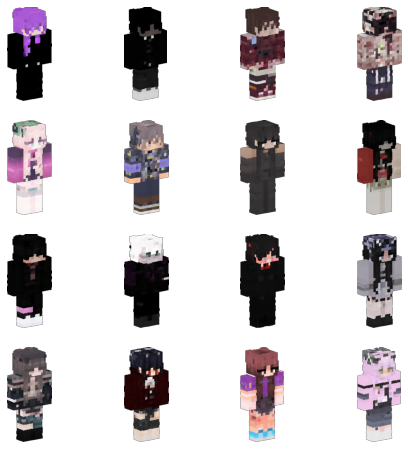

100%|██████████| 1000/1000 [06:26<00:00,  2.59steps/s]


In [ ]:
model = good_model #@param ["general_model", "good_model"] {type:"raw"}

n_samples = 16 #@param {type:"integer"}
sampler = "DDPM" #@param ["DDPM", "DDIM"]
steps = 1000 #@param {type:"integer"}
actions = "Generate unconditional" #@param ["Generate unconditional", "Edit", "Edit + starting image", "Generate variations"]
variability = 1 #@param {type:"slider", min:0, max:1, step:0.001}
display_x0 = False #@param {type:"boolean"}
render = True #@param {type:"boolean"}
generate_gif=False #@param {type:"boolean"}
display_frames = 10 #@param {type:"integer"}
gif_frames=60 #@param {type:"integer"}
reference_img_path = "/00a890ad34785611.png" #@param {type:"raw"}
mask_img_path = "/ce1990ed7a9a2a99dde183a3c018d06ed9c4fee8.png" #@param {type:"raw"}
masked_edit_img_path = "/e382df4431280f6dbf496d723d276086af59841f.png" #@param {type:"raw"}


model.eval()
assert torch.cuda.is_available(), "Ensure runtime type is GPU for fast inference"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ddpm = DenoisingDiffusion(model, 1000).to(device)
# Didn't know you could put params in the arguments themselves but ok ig
ddpm.sample(n_samples=n_samples,
            generate_unconditional = actions == "Generate unconditional",
            generate_variations = actions == "Generate variations",
            edits = actions == "Edit",
            masked_edits = actions == "Edit + starting image",
            reference_img_path = None if reference_img_path is None else reference_img_path,
            mask_img_path = None if mask_img_path is None else mask_img_path,
            masked_edit_img_path = None if masked_edit_img_path is None else masked_edit_img_path,
            sampler=sampler,
            denoising_steps=steps,
            render=render,
            display_x0 = display_x0,
            img_variability = variability,
            generate_gif=generate_gif,
            display_frames = display_frames,
            gif_frames=gif_frames)
